In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json, pickle
import argparse

import numpy as np
import pandas as pd
import torch
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from torch.utils.tensorboard import SummaryWriter

In [3]:
%load_ext autoreload
%autoreload 2

from src.vae_models import CVAE
import src.datasets as datasets
import src.utils as utils
import src.preprocess_lib as preprocess_lib
import src.conditioning_lib as conditioning_lib
import src.experiment_lib as experiment_lib
from src.user_encoding_lib import UserEncoder

In [4]:
sns.set_theme(style="whitegrid", font='serif')
sns.set_context("paper", font_scale=2.5)

In [8]:
config_dir = 'runs/forecast'
config_file = 'config.json'

In [9]:
save_dir = 'transfer/test_results_viz'

In [10]:
df_experiment = experiment_lib.collect_results(config_dir, config_file)

In [11]:
df_experiment = experiment_lib.rename_columns(df_experiment)
df_experiment = experiment_lib.add_columns(df_experiment)

[{"variableName": "df_experiment", "type": "pandas", "supportedEngines": ["pandas"], "isLocalVariable": false}]
[{"variableName": "df_experiment", "type": "pandas", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "filter_arr", "type": "series", "supportedEngines": ["pandas"], "isLocalVariable": false}]
[{"variableName": "df_experiment", "type": "pandas", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "df_experiment_filtered", "type": "pandas", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "filter_arr", "type": "series", "supportedEngines": ["pandas"], "isLocalVariable": false}]
[{"variableName": "df_experiment", "type": "pandas", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "df_experiment_filtered", "type": "pandas", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "filter_arr", "type": "series", "supportedEngines": ["pandas"], "isLocalVariabl

In [12]:
filter_arr =    (df_experiment["Number of LDA Topics"] != None) & \
                (np.isin(df_experiment["Number of LDA Topics"], [100])) & \
                (df_experiment["Availability Rate (b)"] == 10) & \
                (df_experiment["Beta"] == 1.0) & \
                (df_experiment["Likelihood Distribution"] != None) & \
                (df_experiment["Number of LDA Clusters"] != None) & \
                (np.isin(df_experiment["Number of LDA Clusters"], [1000])) & \
                (df_experiment["Dropout"] == False) & \
                (df_experiment["Pattern Dictionary Size"] != None) & \
                (np.isin(df_experiment["Pattern Dictionary Size"], [0, 25, 100])) & \
                (df_experiment["data_random_seed"] == 2112) & \
                (df_experiment["epsilon"] == 1e-4)

In [13]:
df_experiment_filtered = df_experiment[filter_arr]
df_experiment_filtered = df_experiment_filtered.sort_values(by=["Pattern Dictionary Size"], ascending=True)
df_experiment_filtered

,data_random_seed,data_dataset_dir,data_dataset_name,data_forecasting,data_test_ratio,data_val_ratio,data_resolution,data_pad,data_ampute_params_a,Availability Rate (b),...,User-Informed,Expected Missing Days,Missing Set Size,Test Set Size,Validation Set Size,Training Set Size,Test Set Ratio,Validation Set Ratio,Missing Set Ratio,Training Set Ratio
0,2112,data,goi4_dp_full_Gipuzkoa,True,0.2,0.2,1,0,0.85,10.0,...,Yes,28.6,197674,459055.2,459055.2,1377165.6,0.184141,0.184141,0.079293,0.552424


In [14]:
df_experiment_filtered["model_folder"]

0    tmp_Oct22_18-57-15
Name: model_folder, dtype: object

In [17]:
configs, models, condition_sets, conditioners = [], [], [], []

utils.blockPrint()
for model_folder in df_experiment_filtered["model_folder"].values:
    with open(f'{config_dir}/{model_folder}/config.json', 'r') as f:
        config = json.load(f)
        configs.append(config)
    trainset, valset, conditioner, user_ids, months, condition_set, X_test, X_missing, num_missing_days, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])
    model = CVAE(input_dim=X_test.shape[1], conditioner=conditioner, **config["model"])
    model.load(load_path=f'{config_dir}/{model_folder}')
    models.append(model)
    condition_sets.append(condition_set)
    conditioners.append(conditioner)
utils.enablePrint()

In [18]:
## value counts in user_ids["missing"]
unique_missing_ids, missing_counts = np.unique(user_ids["missing"], return_counts=True)

In [19]:
random_seed = 42
np.random.seed(random_seed)

In [20]:
SET_TYPE = "missing" # "missing" or "test"

if SET_TYPE == "missing":
    user_idx = unique_missing_ids[np.random.choice(np.where(missing_counts > 7)[0], size=(1,))[0]]
    idx = np.where(user_ids["missing"] == user_idx)[0]
    middle_mask = np.zeros(len(idx))+1
    # middle_mask[middle_mask.shape[0]//2-7:middle_mask.shape[0]//2+7] = 1
    middle_mask = middle_mask.astype(bool)
    idx = idx[middle_mask]
    X_denormalized = torch.tensor(X_missing[idx]).float()
    X = utils.zero_preserved_log_normalize(X_denormalized, nonzero_mean, nonzero_std, log_output=configs[0]["data"]["scaling"]["log_space"], zero_id=configs[0]["data"]["scaling"]["zero_id"], shift=configs[0]["data"]["scaling"]["shift"])
    X = torch.tensor(X).float()
elif SET_TYPE == "test":
    idx = np.random.randint(X_test.shape[0], size=(1,))
    X = torch.tensor(X_test[idx]).float()
    X_denormalized = utils.zero_preserved_log_denormalize(X, nonzero_mean, nonzero_std, log_input=configs[0]["data"]["scaling"]["log_space"], zero_id=configs[0]["data"]["scaling"]["zero_id"], shift=configs[0]["data"]["scaling"]["shift"])
    X_denormalized = torch.tensor(X_denormalized).float()

In [21]:
NUM_POSTERIOR_SAMPLES = 10000
NUM_PRIOR_SAMPLES =  NUM_POSTERIOR_SAMPLES
NUM_LIKELIHOOD_SAMPLES = 1

In [22]:
params, samples, samples_denorm, kl_divs = [], [], [], []
for i in range(len(models)):
    conditions = torch.tensor(conditioners[i].transform( {k: v[idx] for k, v in condition_sets[i][SET_TYPE].items()})).float()
    x_sample =  models[i].sample(conditions, num_samples_prior=NUM_PRIOR_SAMPLES, num_samples_likelihood=NUM_LIKELIHOOD_SAMPLES)
    _, z_rec = models[i].forward(X, conditions)
    kl_div = models[i].kl_divergence(z_rec["params"]).mean().item()
    kl_divs.append(kl_div)
    params.append(x_sample["params"])
    samples.append(x_sample["samples"])
    samples_denorm.append(utils.zero_preserved_log_denormalize(samples[-1], nonzero_mean, nonzero_std, log_input=configs[i]["data"]["scaling"]["log_space"], zero_id=configs[i]["data"]["scaling"]["zero_id"], shift=configs[i]["data"]["scaling"]["shift"]))

In [23]:
loglikelihoods = []

for i in range(len(models)):
    loglikelihoods.append(models[i].decoder.log_likelihood(X, params[i]).sum(dim=-1).detach())

In [24]:
loglikelihoods[i]

tensor([ 16.0692, 115.4216, 154.0221,  ..., 138.7731,  12.4558, -53.3642])

In [25]:
np.sort(loglikelihoods[i].numpy())[NUM_POSTERIOR_SAMPLES//2]

82.37619

In [26]:
np.mean(loglikelihoods, axis=1)

array([58.12855], dtype=float32)

In [27]:
closest_idx = []
for i in range(len(models)):
    closest_idx.append(np.argsort(loglikelihoods[i].numpy())[::-1].tolist())

In [28]:
num_viz_samples = 50

AttributeError: 'NoneType' object has no attribute 'remove'

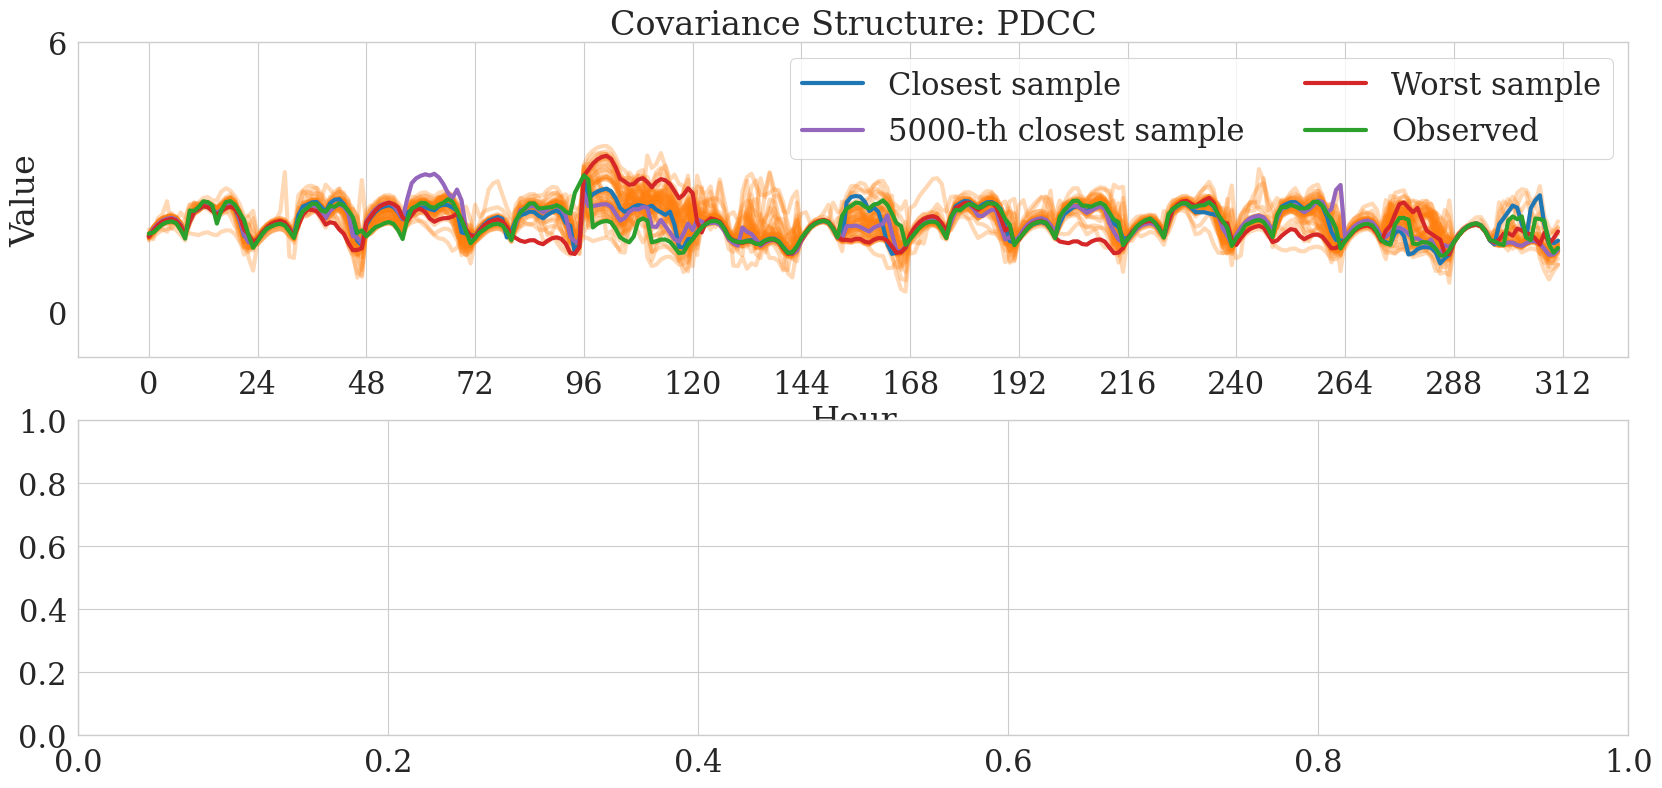

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(20, 9))

for i in range(len(samples)): 
    ax[i].plot(samples[i].reshape(NUM_LIKELIHOOD_SAMPLES*NUM_PRIOR_SAMPLES, -1)[:num_viz_samples].T, alpha=0.3, color="tab:orange", lw=3)

    ax[i].plot((samples[i][:,closest_idx[i][0]]).reshape(1, -1).T, alpha=1.0, color="tab:blue", label=f"Closest sample", lw=3)
    ax[i].plot((samples[i][:,closest_idx[i][NUM_POSTERIOR_SAMPLES//2-1]]).reshape(1, -1).T, alpha=1.0, color="tab:purple", label=f"{NUM_POSTERIOR_SAMPLES//2}-th closest sample", lw=3)
    ax[i].plot((samples[i][:,closest_idx[i][-1]]).reshape(1, -1).T, alpha=1.0, color="tab:red", label=f"Worst sample", lw=3)

    ax[i].plot(np.arange(X.reshape(1,-1).shape[1]), X.reshape(1,-1).T, label="Observed", color="tab:green", alpha=1.0, lw=3)
    ax[i].set_title(f"Covariance Structure: {df_experiment_filtered.iloc[i]['Covariance Structure']}")
    ax[i].set_ylim(-1, max(X.reshape(1,-1).T)*1.5)
    
    ax[i].set_xlabel("Hour")
    ax[i].set_ylabel("Value")
    ax[i].legend(ncol=2)
    ax[i].yaxis.grid(False)
    ax[i].set_xticks(np.arange(0, X.reshape(1,-1).shape[1]+1, 24)) 
    ax[i].set_yticks([0, ax[i].get_yticks()[-1]])
    
    
ax[1].legend_.remove()
ax[0].set_xticklabels([])
ax[0].set_xlabel("")
plt.show()


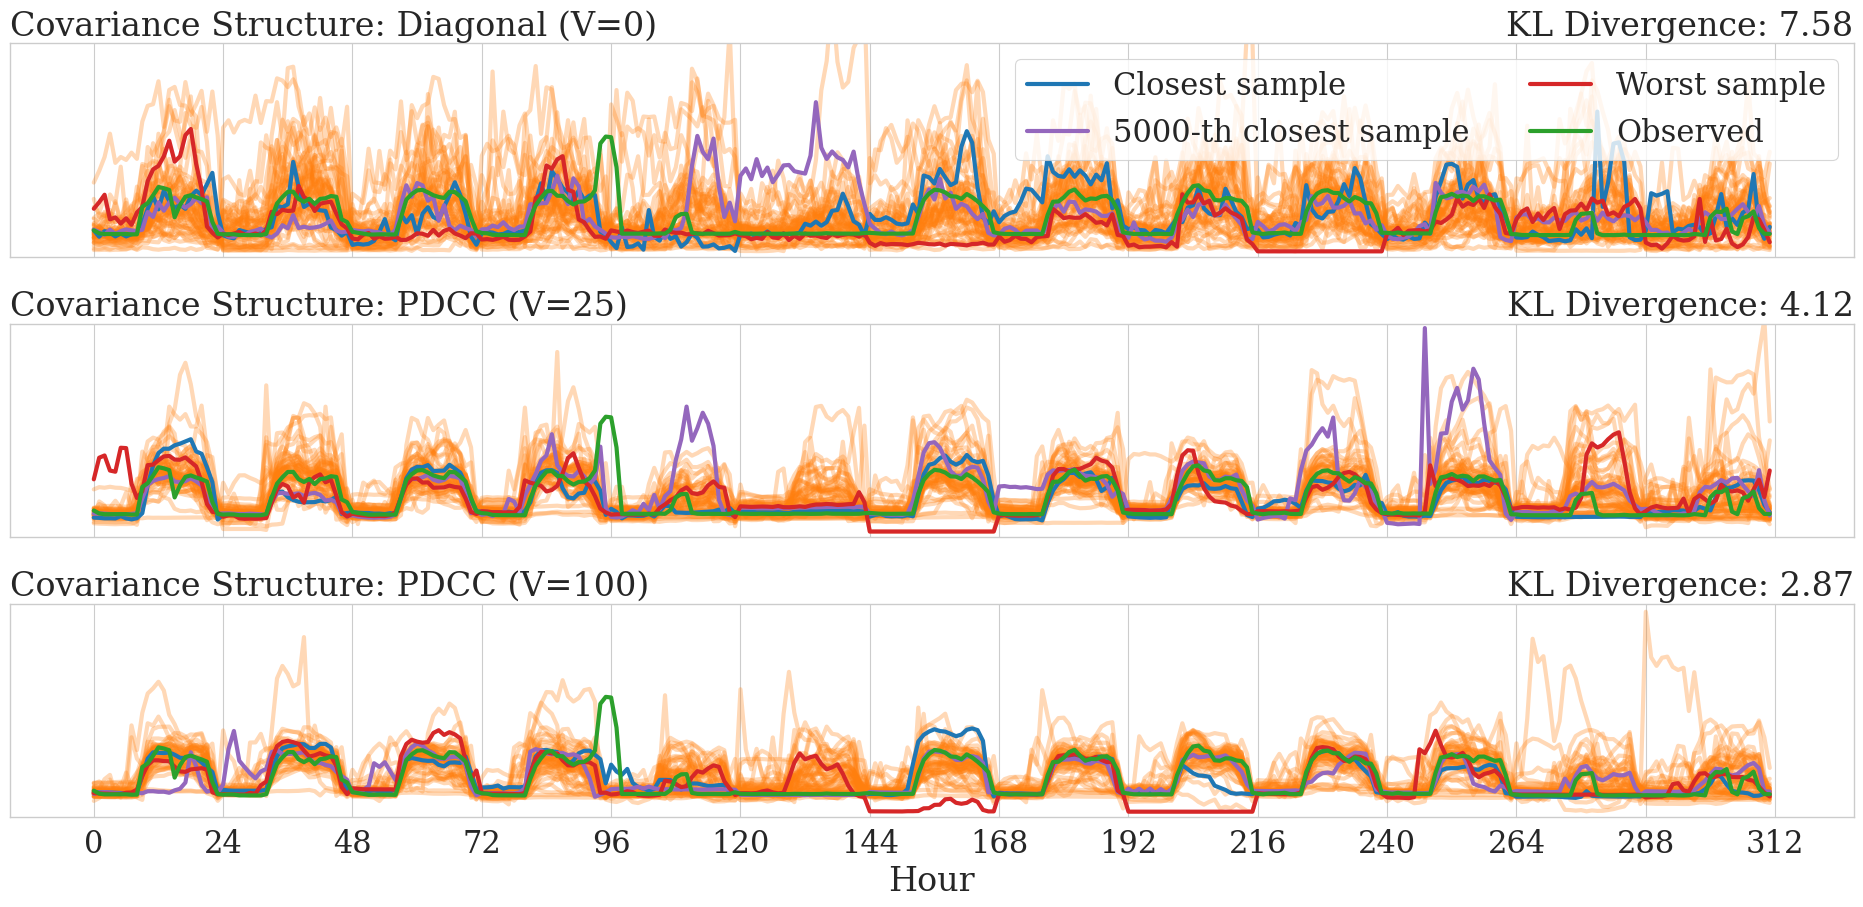

In [225]:
fig, ax = plt.subplots(len(models), 1, figsize=(20, 9), sharex=True)
fig.tight_layout()

for i in range(len(samples_denorm)): 
    ax[i].plot(samples_denorm[i].reshape(NUM_LIKELIHOOD_SAMPLES*NUM_PRIOR_SAMPLES, -1)[:num_viz_samples].T, alpha=0.3, color="tab:orange", lw=3)

    ax[i].plot((samples_denorm[i][:,closest_idx[i][0]]).reshape(1, -1).T, alpha=1.0, color="tab:blue", label=f"Closest sample", lw=3)
    ax[i].plot((samples_denorm[i][:,closest_idx[i][NUM_POSTERIOR_SAMPLES//2-1]]).reshape(1, -1).T, alpha=1.0, color="tab:purple", label=f"{NUM_POSTERIOR_SAMPLES//2}-th closest sample", lw=3)
    ax[i].plot((samples_denorm[i][:,closest_idx[i][-1]]).reshape(1, -1).T, alpha=1.0, color="tab:red", label=f"Worst sample", lw=3)

    ax[i].plot(np.arange(X_denormalized.reshape(1,-1).shape[1]), X_denormalized.reshape(1,-1).T, label="Observed", color="tab:green", alpha=1.0, lw=3)
    ax[i].set_title(f"Covariance Structure: {df_experiment_filtered.iloc[i]['Covariance Structure']} (V={df_experiment_filtered.iloc[i]['Pattern Dictionary Size']})", loc="left")
    ax[i].set_title(f"KL Divergence: {kl_divs[i]:.2f}", loc="right")
    ax[i].set_ylim(-100, max(X_denormalized.reshape(1,-1).T)*1.5)
    ax[i].set_xlabel("Hour")
    # ax[i].set_ylabel("Value")
    ax[i].legend(ncol=2)
    ax[i].yaxis.grid(False)
    ax[i].set_xticks(np.arange(0, X.reshape(1,-1).shape[1]+1, 24))
    ax[i].set_yticks([0, ax[i].get_yticks()[-1]])
    ax[i].set_yticks([])

for i in range(len(models)-1):
    ax[len(models)-1-i].legend_.remove()
    ax[i].set_xlabel("")


In [33]:
from scipy.interpolate import *

interpolator = PchipInterpolator

UPSCALE_FACTOR = 10
tnew = np.linspace(0, X.shape[0]*X.shape[1], X.shape[0]*X.shape[1]*UPSCALE_FACTOR)

In [34]:
spl = interpolator(np.arange(X.shape[0]*X.shape[1]), X.reshape(-1))
X_smooth = spl(tnew)

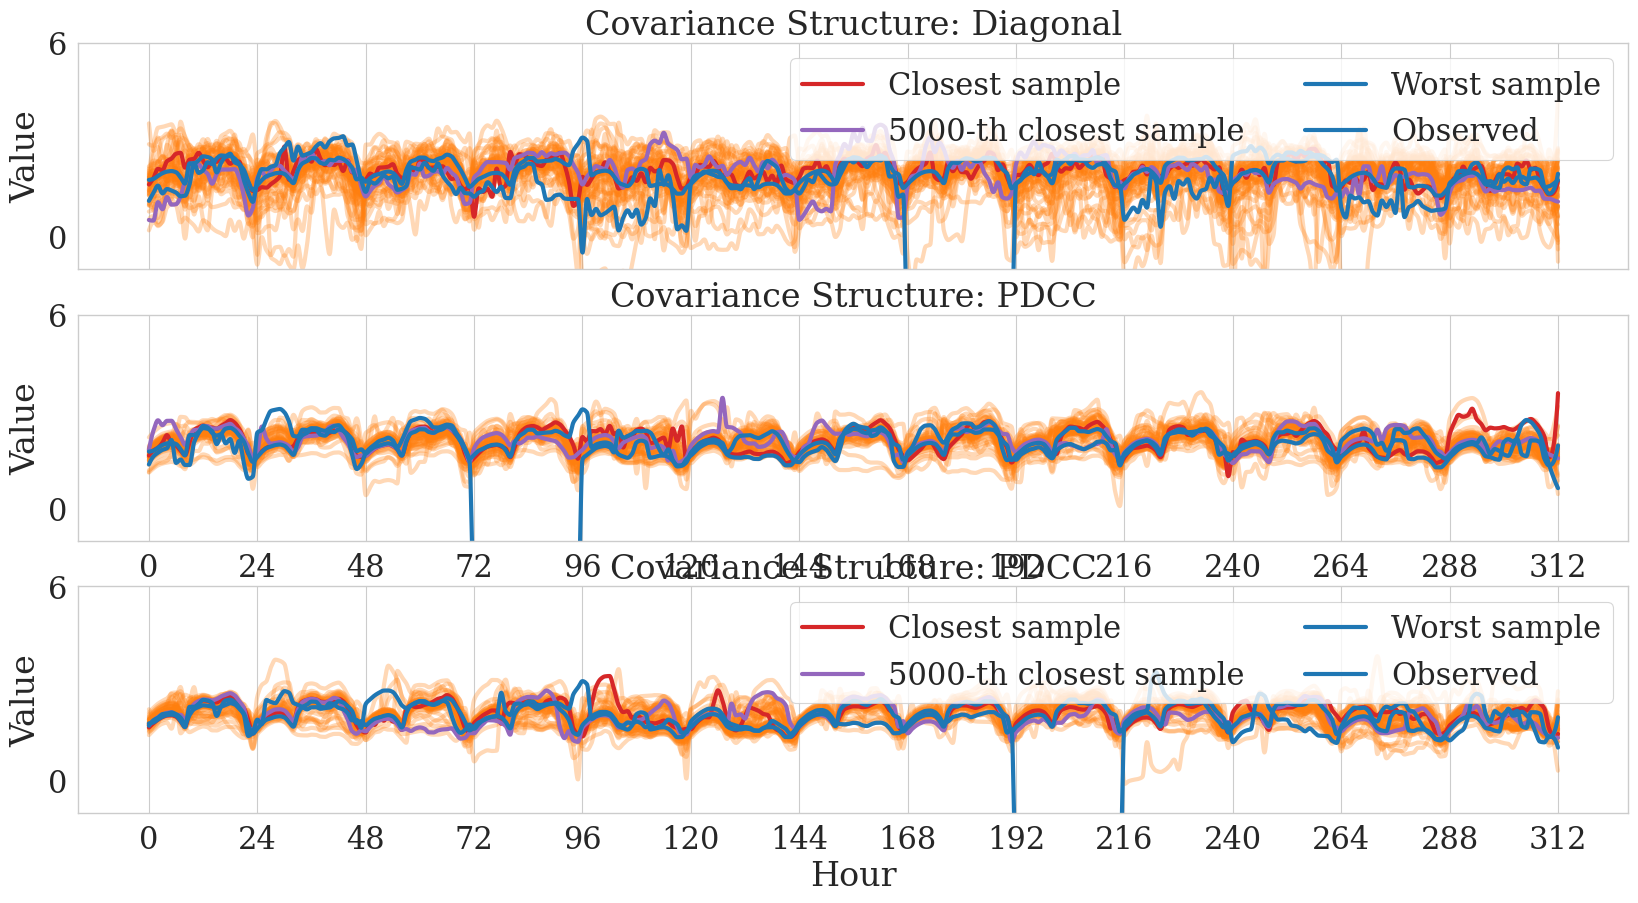

In [206]:
fig, ax = plt.subplots(len(models), 1, figsize=(20, 10))
for i in range(len(samples)):
    samples_ = samples[i].reshape(NUM_LIKELIHOOD_SAMPLES*NUM_PRIOR_SAMPLES, -1)[:num_viz_samples]
    for j in range(len(samples_)):
        spl = interpolator(np.arange(X.shape[0]*X.shape[1]), samples_[j].T)
        x_sample_smooth = spl(tnew)
        ax[i].plot(tnew, x_sample_smooth.T, alpha=0.3, color="tab:orange", lw=3)
    
    closest_samples = samples[i][:,closest_idx[i]].reshape(NUM_POSTERIOR_SAMPLES, -1)

    spl = interpolator(np.arange(X.shape[0]*X.shape[1]), closest_samples[0].T)
    x_sample_smooth = spl(tnew)
    ax[i].plot(tnew, x_sample_smooth.T, alpha=1.0, color="tab:red", lw=3, label="Closest sample")

    spl = interpolator(np.arange(X.shape[0]*X.shape[1]), closest_samples[NUM_POSTERIOR_SAMPLES//2-1].T)
    x_sample_smooth = spl(tnew)
    ax[i].plot(tnew, x_sample_smooth.T, alpha=1.0, color="tab:purple", lw=3, label=f"{NUM_POSTERIOR_SAMPLES//2}-th closest sample")

    spl = interpolator(np.arange(X.shape[0]*X.shape[1]), closest_samples[-1].T)
    x_sample_smooth = spl(tnew)
    ax[i].plot(tnew, x_sample_smooth.T, alpha=1.0, color="tab:blue", lw=3, label="Worst sample")

    ax[i].plot(tnew, X_smooth, label="Observed", color="tab:blue", alpha=1.0, lw=3)
    ax[i].set_title(f"Covariance Structure: {df_experiment_filtered.iloc[i]['Covariance Structure']}")
    ax[i].set_ylim(-1, np.max(X_smooth)*1.5)
    ax[i].set_xlabel("Hour")
    ax[i].set_ylabel("Value")
    ax[i].legend(ncol=2)
    ax[i].yaxis.grid(False)
    ax[i].set_xticks(np.arange(0, X.reshape(1,-1).shape[1]+1, 24))
    ax[i].set_yticks([0, ax[i].get_yticks()[-1]])
    
ax[1].legend_.remove()
ax[0].set_xticklabels([])
ax[0].set_xlabel("")
plt.show()

In [35]:
tnew_ = np.linspace(0, nonzero_mean.shape[1], nonzero_mean.shape[1]*UPSCALE_FACTOR)
spl = interpolator(np.arange(nonzero_mean.shape[1]), nonzero_mean[0])
nonzero_mean_upscaled = spl(tnew_)[None,...]
spl = interpolator(np.arange(nonzero_std.shape[1]), nonzero_std[0])
nonzero_std_upscaled = spl(tnew_)[None,...]

In [36]:
X_denormalized_smooth = utils.zero_preserved_log_denormalize(np.reshape(X_smooth, (-1, nonzero_mean_upscaled.shape[1])), nonzero_mean_upscaled, nonzero_std_upscaled, log_input=configs[0]["data"]["scaling"]["log_space"], zero_id=configs[0]["data"]["scaling"]["zero_id"], shift=configs[0]["data"]["scaling"]["shift"])
X_denormalized_smooth = np.reshape(X_denormalized_smooth, (-1))

/tmp/ipykernel_2036755/2692527144.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  spl = interpolator(np.arange(X_denormalized.shape[0]*X_denormalized.shape[1]), samples_[j].T)


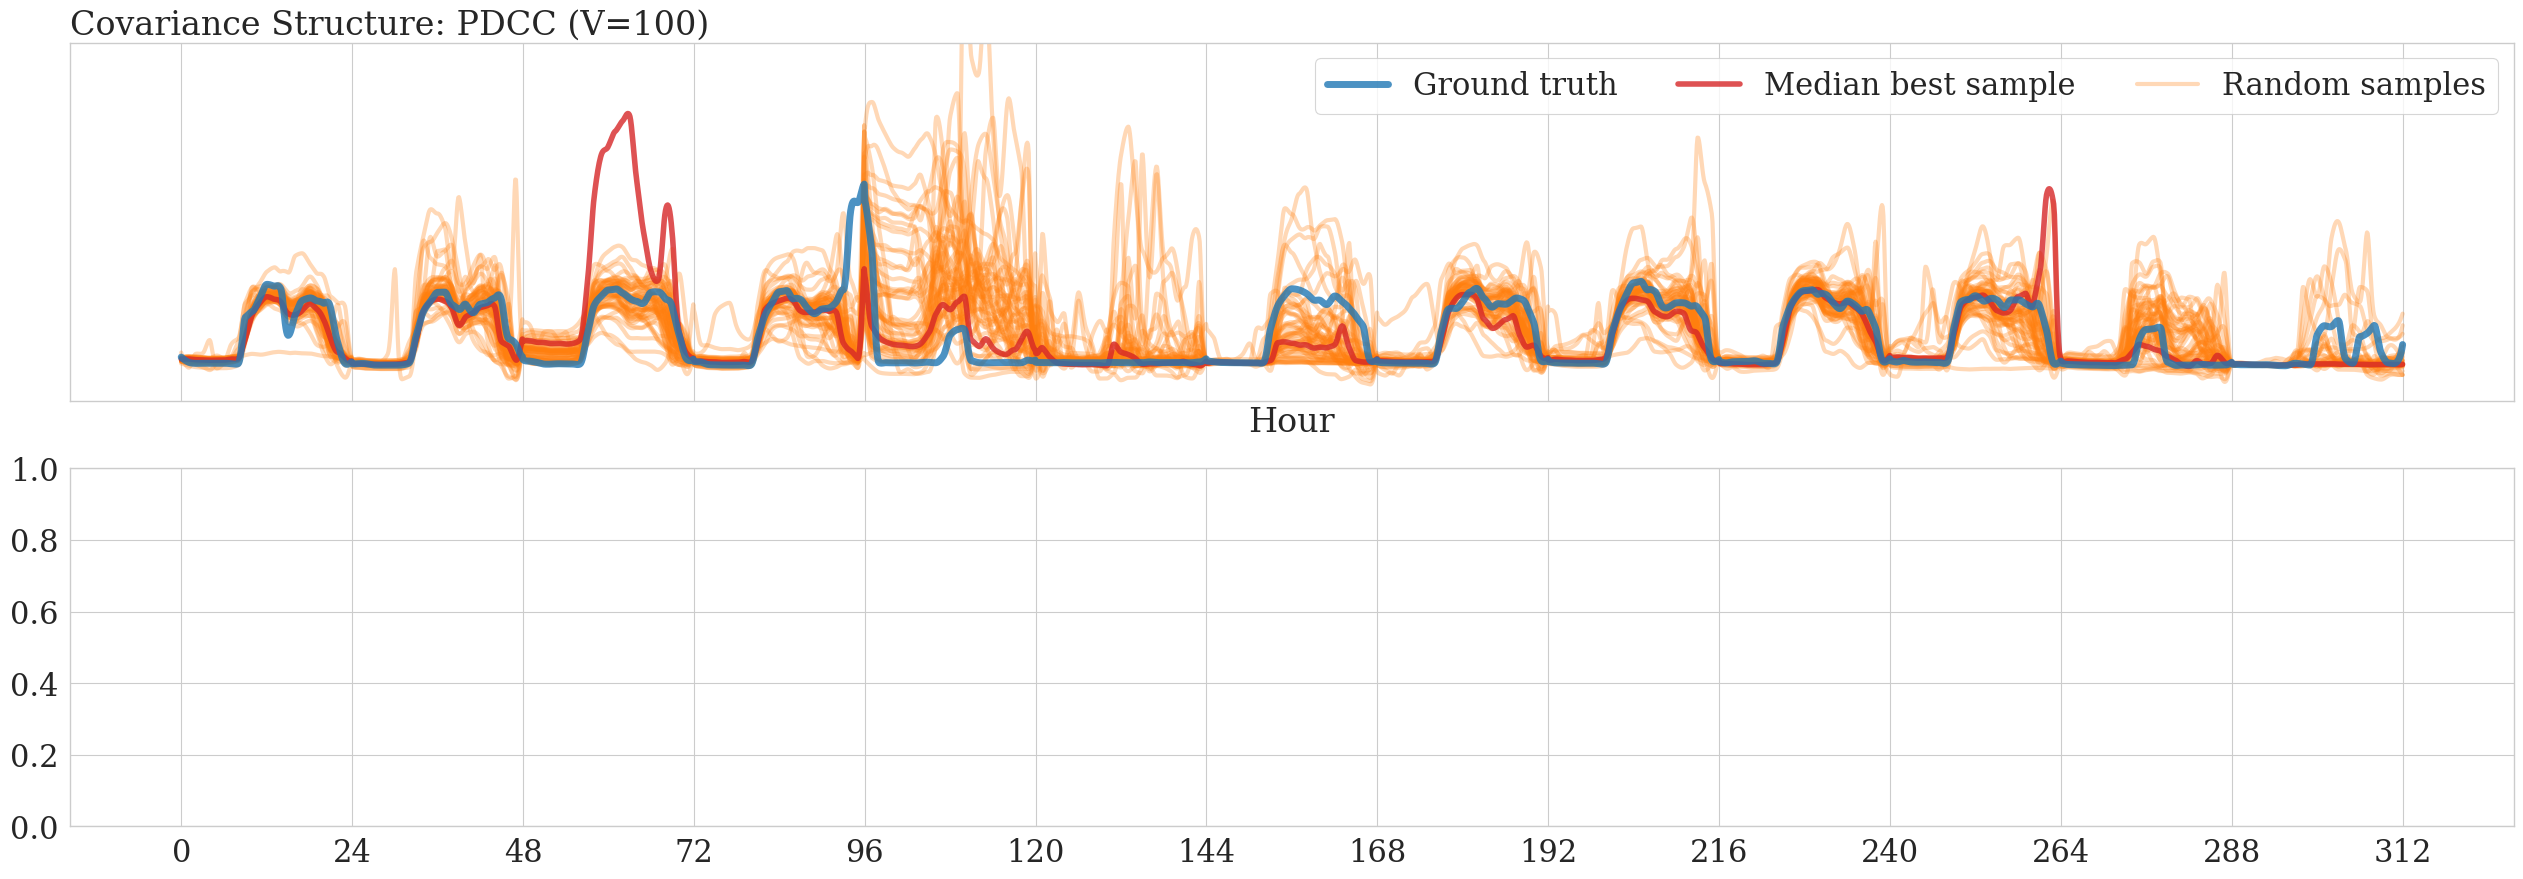

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(20*1.3, 7*1.3), sharex=True)
fig.tight_layout()

for i in range(len(samples)):
    samples_ = samples[i].reshape(NUM_LIKELIHOOD_SAMPLES*NUM_PRIOR_SAMPLES, -1)[:num_viz_samples]
    for j in range(len(samples_)):
        spl = interpolator(np.arange(X_denormalized.shape[0]*X_denormalized.shape[1]), samples_[j].T)
        x_sample_smooth = spl(tnew)
        x_sample_smooth_denorm = utils.zero_preserved_log_denormalize(np.reshape(x_sample_smooth, (-1, nonzero_mean_upscaled.shape[1])), nonzero_mean_upscaled, nonzero_std_upscaled, log_input=configs[i]["data"]["scaling"]["log_space"], zero_id=configs[i]["data"]["scaling"]["zero_id"], shift=configs[i]["data"]["scaling"]["shift"])
        x_sample_smooth_denorm = np.reshape(x_sample_smooth_denorm, (-1))
        ax[i].plot(tnew, x_sample_smooth_denorm.T, alpha=0.3, color="tab:orange", lw=3, label= "Random samples" if j==0 else None)
    
    closest_samples = samples[i][:,closest_idx[i]].reshape(NUM_POSTERIOR_SAMPLES, -1)

    # spl = interpolator(np.arange(X.shape[0]*X.shape[1]), samples[i][:,closest_idx[i][-1]].reshape(1,-1).T)
    # x_sample_smooth = spl(tnew)
    # x_sample_smooth_denorm = utils.zero_preserved_log_denormalize(np.reshape(x_sample_smooth, (-1, nonzero_mean_upscaled.shape[1])), nonzero_mean_upscaled, nonzero_std_upscaled, log_input=configs[i]["data"]["scaling"]["log_space"], zero_id=configs[i]["data"]["scaling"]["zero_id"], shift=configs[i]["data"]["scaling"]["shift"])
    # x_sample_smooth_denorm = np.reshape(x_sample_smooth_denorm, (-1))
    # ax[i].plot(tnew, x_sample_smooth_denorm.T, alpha=0.8, color="tab:red", lw=4, label="Worst sample")

    spl = interpolator(np.arange(X.shape[0]*X.shape[1]), samples[i][:,closest_idx[i][NUM_POSTERIOR_SAMPLES//2-1]].reshape(1,-1).T)
    x_sample_smooth = spl(tnew)
    x_sample_smooth_denorm = utils.zero_preserved_log_denormalize(np.reshape(x_sample_smooth, (-1, nonzero_mean_upscaled.shape[1])), nonzero_mean_upscaled, nonzero_std_upscaled, log_input=configs[i]["data"]["scaling"]["log_space"], zero_id=configs[i]["data"]["scaling"]["zero_id"], shift=configs[i]["data"]["scaling"]["shift"])
    x_sample_smooth_denorm = np.reshape(x_sample_smooth_denorm, (-1))
    ax[i].plot(tnew, x_sample_smooth_denorm.T, alpha=0.8, color="tab:red", lw=4, label=f"Median best sample")

    # spl = interpolator(np.arange(X.shape[0]*X.shape[1]), samples[i][:,closest_idx[i][0]].reshape(1,-1).T)
    # x_sample_smooth = spl(tnew)
    # x_sample_smooth_denorm = utils.zero_preserved_log_denormalize(np.reshape(x_sample_smooth, (-1, nonzero_mean_upscaled.shape[1])), nonzero_mean_upscaled, nonzero_std_upscaled, log_input=configs[i]["data"]["scaling"]["log_space"], zero_id=configs[i]["data"]["scaling"]["zero_id"], shift=configs[i]["data"]["scaling"]["shift"])
    # x_sample_smooth_denorm = np.reshape(x_sample_smooth_denorm, (-1))
    # ax[i].plot(tnew, x_sample_smooth_denorm.T, alpha=0.8, color="tab:blue", lw=4, label="Closest sample")

    ax[i].plot(tnew, X_denormalized_smooth, label="Ground truth", color="tab:blue", alpha=0.8, lw=5)
    ax[i].set_title(f"Covariance Structure: {df_experiment_filtered.iloc[i]['Covariance Structure']} (V={df_experiment_filtered.iloc[i]['Pattern Dictionary Size']})", loc="left")
    ax[i].set_ylim(-100, np.max(X_denormalized_smooth)*1.5)
    ax[i].set_xlabel("Hour")
    ax[i].legend(ncol=5, loc="upper right", bbox_to_anchor=(0.875, -0.5))
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend(handles[::-1], labels[::-1], ncol=5, loc="upper right")
    ax[i].yaxis.grid(False)
    ax[i].set_xticks(np.arange(0, X.reshape(1,-1).shape[1]+1, 24))
    ax[i].set_yticks([0, ax[i].get_yticks()[-1]])
    ax[i].set_yticks([])

for i in range(len(models)-1):
    ax[len(models)-1-i].legend_.remove()
    ax[i].set_xlabel("")

if os.path.exists(save_dir): 
    plt.savefig(os.path.join(save_dir, f'sample_comparison.png'), bbox_inches='tight', dpi=300)
plt.show()